# Li NYC Subway Ridership Project
Brian Li \
10/01/2023

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely
import seaborn as sns
import esda.moran
import esda.getisord
import splot.esda
import contextily as cx

# others here

This data represents total ridership (defined as rider entries via the turnstiles) for all MTA stations from February 1st 2022 through October 1st 2023.

The data was sourced from the State of New York and the Metropolitan Transportation Agency via their open data portal here: https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-Beginning-February-202/wujg-7c2s.

This data is of interest to me because public transit in the US is an interest of mine.

In [3]:
# stations = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=GeoJSON")
# ridership = pd.read_csv("https://raw.githubusercontent.com/ugin331/GGIS-371/main/2021%20Subway%20Tables_ul.csv", skiprows=1)
stations = gpd.read_file("https://raw.githubusercontent.com/ugin331/GGIS-371/main/MTA%20Subway%20Hourly%20Ridership%20Beginning%20February%202022.geojson")
neighborhoods = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/yfnk-k7r4?method=export&format=GeoJSON")

In [4]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   station_complex  425 non-null    object  
 1   sum_ridership    425 non-null    object  
 2   geometry         425 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 10.1+ KB


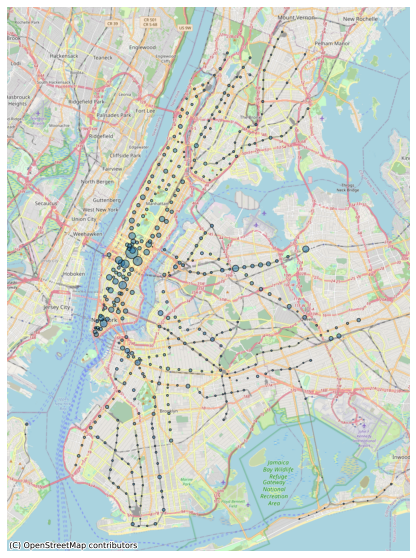

In [8]:
stations = stations.to_crs(epsg=3857)
stations["sum_ridership"] = pd.to_numeric(stations["sum_ridership"])
bubble_size = 150 * stations["sum_ridership"] / max(stations["sum_ridership"])
ax = stations.plot(figsize=(10, 10), alpha=0.5, edgecolor="k", markersize=bubble_size)
ax.axis('off')
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)

Over the past 18 month period (02/02/2022 - 10/01/2023), the median ridership per station for the NYC Subway system was 2,411,569.0. The gra The top few stations in the system by ridership are largely to blame for this phenomenon, with Times Square-42nd Street Station accounting for 80,399,994 passengers over that period, nearly 3 orders of magnitude higher than the least-used station on the system during this period, Broad Channel Station.

<AxesSubplot:xlabel='sum_ridership', ylabel='Count'>

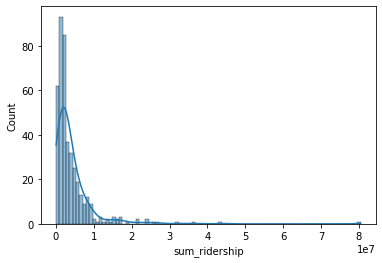

In [10]:
# stations_norm = stations.copy()
# stations_norm["sum_ridership"] = stations["sum_ridership"] / max(stations["sum_ridership"])
sns.histplot(stations["sum_ridership"], kde=True)

In [11]:
stations_sorted = stations.sort_values("sum_ridership", ascending=False)
stations_sorted = stations_sorted.reset_index()
stations_sorted.head()

,index,station_complex,sum_ridership,geometry
0,209,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",80399994.0,POINT (-8235634.573 4976610.427)
1,391,"Grand Central-42 St (S,4,5,6,7)",43721404.0,POINT (-8235064.692 4975797.579)
2,415,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",36437904.0,POINT (-8236286.835 4975494.881)
3,377,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",32113521.0,POINT (-8236523.790 4973440.704)
4,321,"Fulton St (A,C,J,Z,2,3,4,5)",26891320.0,POINT (-8238373.566 4969715.141)


In [12]:
stations_sorted.tail()

,index,station_complex,sum_ridership,geometry
420,137,Beach 44 St (A),226812.0,POINT (-8212708.560 4952484.738)
421,250,Tompkinsville,226128.0,POINT (-8245972.913 4958938.310)
422,421,"Beach 98 St (A,S)",167459.0,POINT (-8217666.775 4951365.788)
423,130,"Beach 105 St (A,S)",110217.0,POINT (-8218446.433 4951058.252)
424,315,"Broad Channel (A,S)",94538.0,POINT (-8217151.250 4954748.752)


In [13]:
print("The median ridership over the past 18 months is " + str(stations["sum_ridership"].median()) + " passengers.")

The median ridership over the past 18 months is 2411569.0 passengers.


The following kernel density map demonstrates that, when weighted for ridership, there is the most clustering in Manhattan downtown.

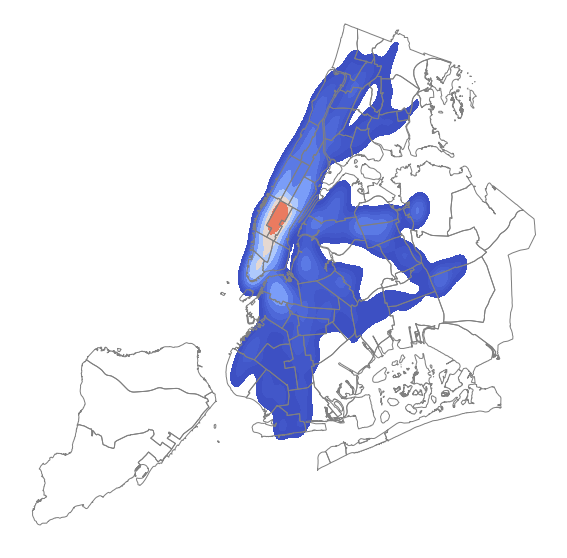

In [67]:
neighborhoods = neighborhoods.to_crs(epsg=3857)
plt.figure(figsize=(10, 10))
axis = sns.kdeplot(x = stations.centroid.x, y = stations.centroid.y, weights = stations["sum_ridership"], fill=True, gridsize=100, bw_adjust=0.3, cmap="coolwarm")
axis.set_axis_off()
neighborhoods.plot(facecolor="none", edgecolor="gray", ax=axis)
# cx.add_basemap(axis)
plt.show()

The below figure reinforces the KDE analysis from earlier, showing that Manhattan Community District 5, which contains Midtown and Times Square, accounts for 19.20% of all subway ridership in New York City. Stations in Manhattan and Queens are by far the busiest compared to stations in the Bronx, which are some of the least busy.

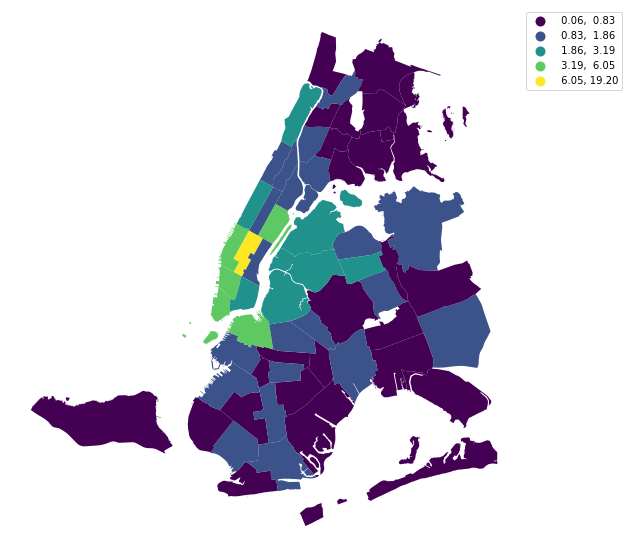

In [92]:
neighborhood_stns = stations.sjoin(neighborhoods)
neighborhood_stns = neighborhood_stns.groupby("boro_cd")["sum_ridership"].sum()
neighborhood_stns = neighborhood_stns.reset_index()
neighborhood_stns = neighborhood_riders.merge(neighborhood_stns)
# print(neighborhood_stns.head())
neighborhood_stns["total_percent"] = 100 * neighborhood_stns["sum_ridership"] / neighborhood_stns["sum_ridership"].sum()

axis = neighborhood_stns.plot("total_percent", scheme="naturalbreaks", cmap="viridis", legend=True, legend_kwds=dict(loc='upper left', bbox_to_anchor=(1, 1)), figsize=(10, 10))
axis.set_axis_off()
plt.show()

In [95]:
neighborhood_stns_sorted = neighborhood_stns.sort_values("total_percent", ascending=False)
neighborhood_stns_sorted = neighborhood_stns_sorted.reset_index()
neighborhood_stns_sorted.head()

,index,boro_cd,shape_area,shape_leng,geometry,sum_ridership,total_percent
0,23,105,43790039.865,35288.3342981,"MULTIPOLYGON (((-8234638.348 4977634.779, -823...",342601877.0,19.198630
1,53,101,41692711.6252,69093.8528032,"MULTIPOLYGON (((-8242526.753 4966751.259, -824...",108030751.0,6.053798
2,27,104,49310051.9094,67546.0454574,"MULTIPOLYGON (((-8236967.382 4978943.041, -823...",95634180.0,5.359122
3,22,108,55215029.0836,53753.3536852,"MULTIPOLYGON (((-8231163.561 4978335.590, -823...",84275445.0,4.722604
4,50,102,37604933.3646,32628.8675927,"MULTIPOLYGON (((-8237290.542 4973679.298, -823...",79569421.0,4.458889


A global Moran's I value of 0.27 indicates significant spatial autocorrelation of NYC subway stations.

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.0/lib/python3.8/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


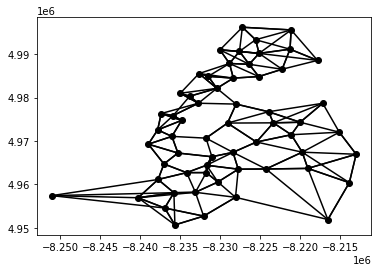

In [103]:
import pysal.lib
import pysal.model

neighborhood_stns["ID"] = range(neighborhood_stns.shape[0])
stn_weights = pysal.lib.weights.KNN.from_dataframe(neighborhood_stns, ids="ID", k=4)
stn_weights.plot(gdf=neighborhood_stns, indexed_on="ID")
plt.show()

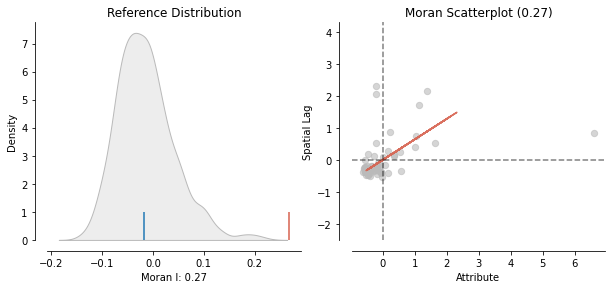

In [104]:
neighborhood_stns["sum_ridership"] = neighborhood_stns["sum_ridership"].fillna(0)
moran = esda.moran.Moran(neighborhood_stns["sum_ridership"], stn_weights)
splot.esda.plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

There is a hot spot around Manhattan Downtown/Times Square, with some boroughs (notably Central Park and the area around Murray Hill) being low outliers in the region. There are also several cold spots, mostly in the Bronx and near the end of the A line at Rockaway Park in Queens.

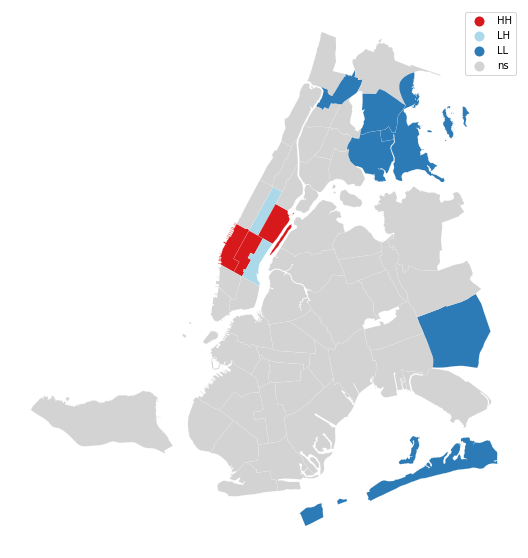

In [106]:
moran_local = esda.moran.Moran_Local(neighborhood_stns["sum_ridership"], stn_weights)
splot.esda.lisa_cluster(moran_local, neighborhood_stns[["sum_ridership", "geometry"]], figsize=(10, 10))
plt.show()